In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = kagglehub.dataset_download("karimabdulnabi/fruit-classification10-class")
print("Path to dataset files:", path)

100%|██████████| 29.2M/29.2M [00:00<00:00, 216MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karimabdulnabi/fruit-classification10-class/versions/1


In [2]:
folder_path = "/root/.cache/kagglehub/datasets/karimabdulnabi/fruit-classification10-class/versions/1"
files = os.listdir(folder_path)
print(files)

['MY_data']


In [3]:
import shutil
source = folder_path+"/MY_data"
shutil.copytree(source, os.path.join("/content", "my_data"), dirs_exist_ok=True)

'/content/my_data'

In [4]:
train_dir = "/content/my_data/train"
val_dir = "/content/my_data/test"
batch_size = 32
img_size = (128, 128)
# Tạo ImageDataGenerators cho tập huấn luyện, kiểm tra và xác thực
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


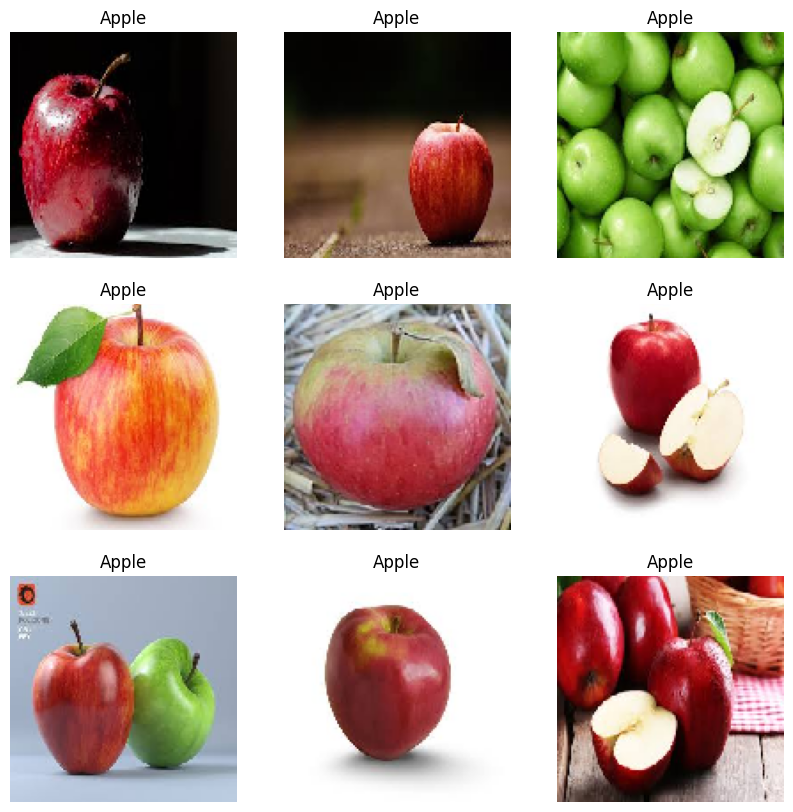

In [5]:
# Tạo ánh xạ từ nhãn số nguyên sang tên lớp
data_cat = {v: k for k, v in train_data.class_indices.items()}

# Lấy batch đầu tiên từ train_data
images, labels = next(train_data)

# Vẽ 9 ảnh đầu tiên
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(data_cat[np.argmax(labels[i])])  # Chuyển nhãn one-hot thành tên lớp
    plt.axis('off')

plt.show()

In [6]:
# Chuyển đổi dữ liệu thành định dạng numpy để sử dụng với các mô hình ML
def extract_features(data):
    features, labels = [], []
    for inputs_batch, labels_batch in data:
        features.append(inputs_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= data.samples:
            break
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels
# Chuẩn bị dữ liệu huấn luyện, kiểm tra, và xác thực
train_features, train_labels = extract_features(train_data)
val_features, val_labels = extract_features(val_data)
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
# Chuyển đổi hình ảnh thành vector 1D
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

In [7]:
from tensorflow.keras.applications import VGG16
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
feature_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def extract_features(data_generator, feature_extractor):
    features = []
    labels = []

    # Flatten the feature maps for compatibility with sklearn classifiers
    for batch_images, batch_labels in data_generator:
        # Extract features and flatten them
        batch_features = feature_extractor.predict(batch_images)
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)

        features.append(batch_features_flat)
        labels.append(batch_labels)

        # Break when all samples are processed
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break

    # Convert lists to numpy arrays
    features = np.vstack(features)
    labels = np.argmax(np.vstack(labels), axis=1)

    return features, labels

train_features_cnn, train_labels_cnn = extract_features(train_data, feature_extractor)
val_features_cnn, val_labels_cnn = extract_features(val_data, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━

In [10]:
print(len(train_features_cnn[0]))

8192


In [11]:
#knn
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier()

In [12]:
#svc
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(train_features, train_labels)

SVC(C=1, kernel='linear')

In [13]:
#random forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None)
rf_model.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=200, random_state=42)

## Huấn luyện ba mô hình KNN, SVM và Random Forest với dữ liệu đã trích xuất với cnn

In [14]:
#knn
knn_model_cnn = KNeighborsClassifier(n_neighbors=5)
knn_model_cnn.fit(train_features_cnn, train_labels_cnn)

KNeighborsClassifier()

In [15]:
#svc
svm_model_cnn = SVC(kernel='linear', C=1, probability=True)
svm_model_cnn.fit(train_features_cnn, train_labels_cnn)

SVC(C=1, kernel='linear', probability=True)

In [16]:
#random forest
rf_model_cnn = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None)
rf_model_cnn.fit(train_features_cnn, train_labels_cnn)

RandomForestClassifier(n_estimators=200, random_state=42)

In [19]:
# Hàm đánh giá mô hình
def evaluate_model(model, X, y_true, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, average='weighted') * 100
    rec = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    cm = confusion_matrix(y_true, y_pred)

    print()
    print(f'Đánh giá mô hình {model_name}')
    print(f"Accuracy: {acc:.2f}")
    print(f"F1-Score: {f1:.2f}")
    # Vẽ Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_cat.values(), yticklabels=data_cat.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


    return model_name,acc, prec, rec, f1

# Lưu kết quả vào danh sách
results = []

# Danh sách các mô hình và dữ liệu đầu vào tương ứng
models = [
    ("KNN", knn_model, val_features, val_labels),
    ("KNN_cnn", knn_model_cnn, val_features_cnn, val_labels_cnn),
    ("SVM", svm_model, val_features, val_labels),
    ("SVM_cnn", svm_model_cnn, val_features_cnn, val_labels_cnn),
    ("Random Forest", rf_model, val_features, val_labels),
    ("Random Forest_cnn", rf_model_cnn, val_features_cnn, val_labels_cnn),
]


Đánh giá mô hình KNN
Accuracy: 22.73
F1-Score: 20.21


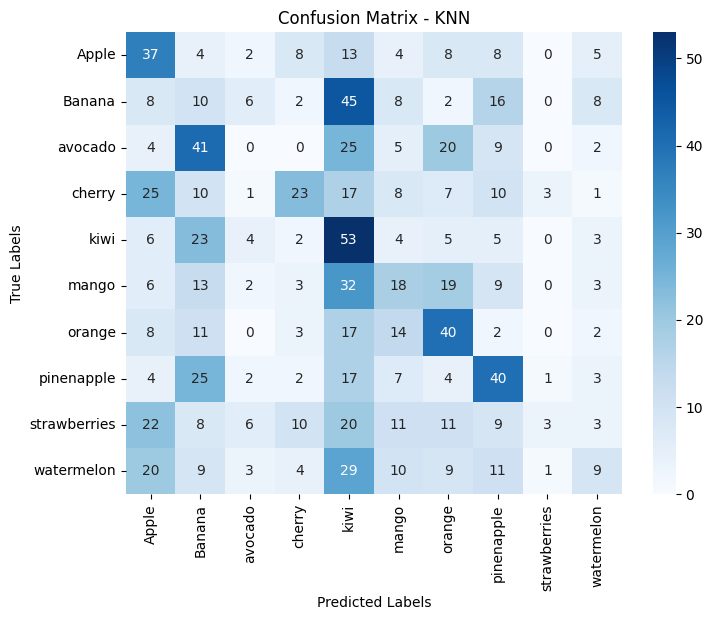


Đánh giá mô hình KNN_cnn
Accuracy: 42.63
F1-Score: 42.90


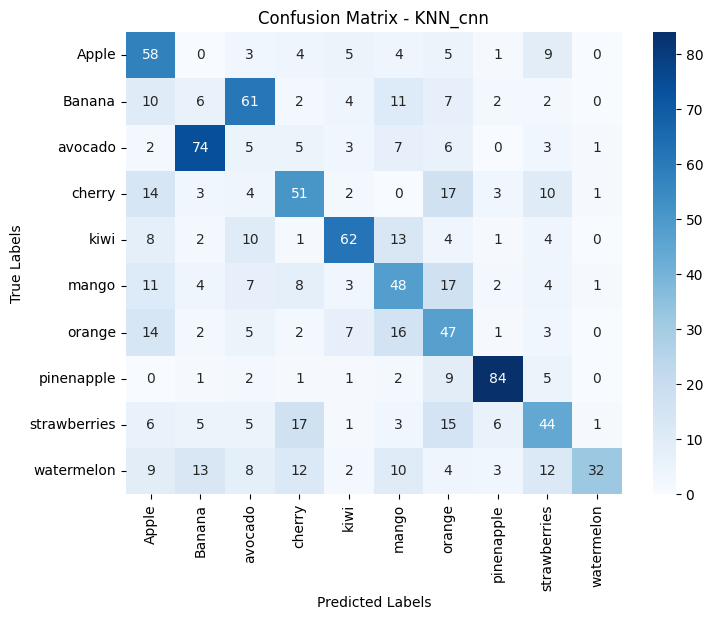


Đánh giá mô hình SVM
Accuracy: 37.37
F1-Score: 36.40


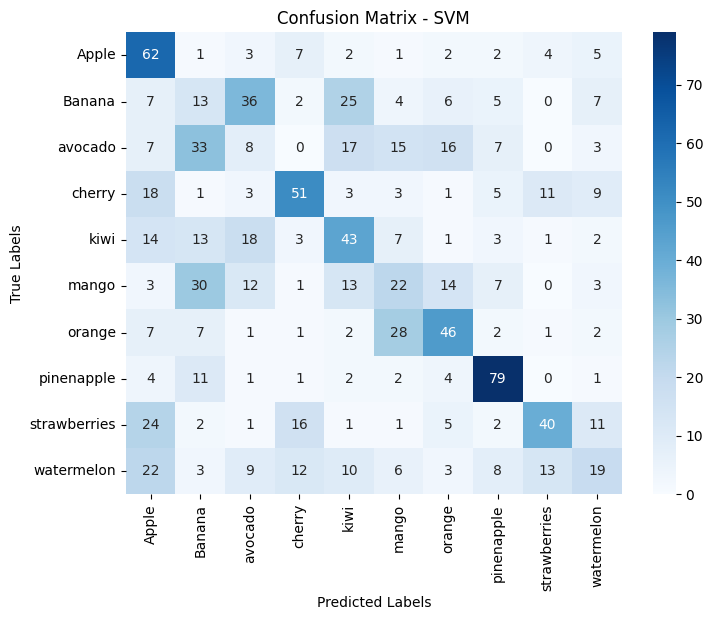


Đánh giá mô hình SVM_cnn
Accuracy: 55.80
F1-Score: 56.34


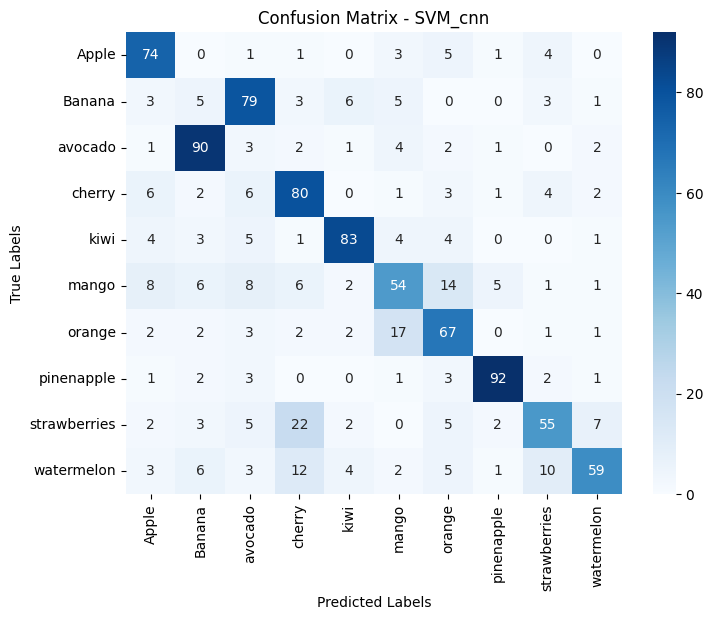


Đánh giá mô hình Random Forest
Accuracy: 45.07
F1-Score: 43.47


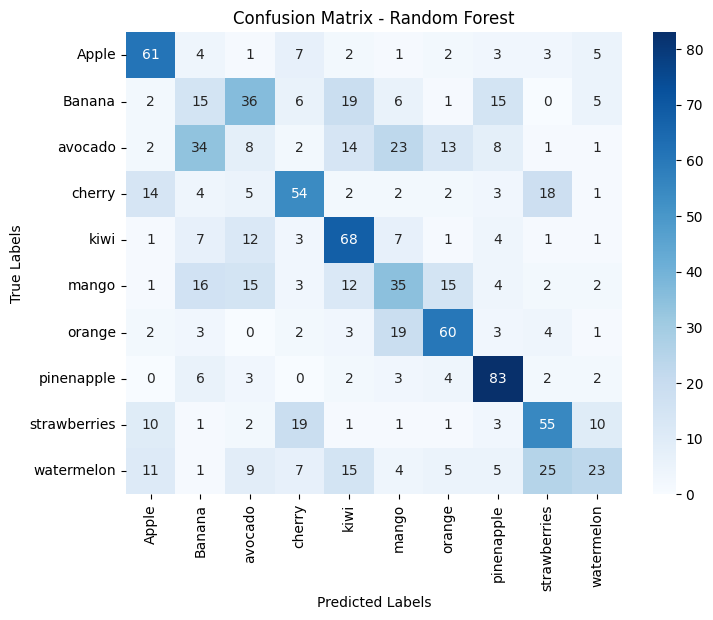


Đánh giá mô hình Random Forest_cnn
Accuracy: 50.44
F1-Score: 50.15


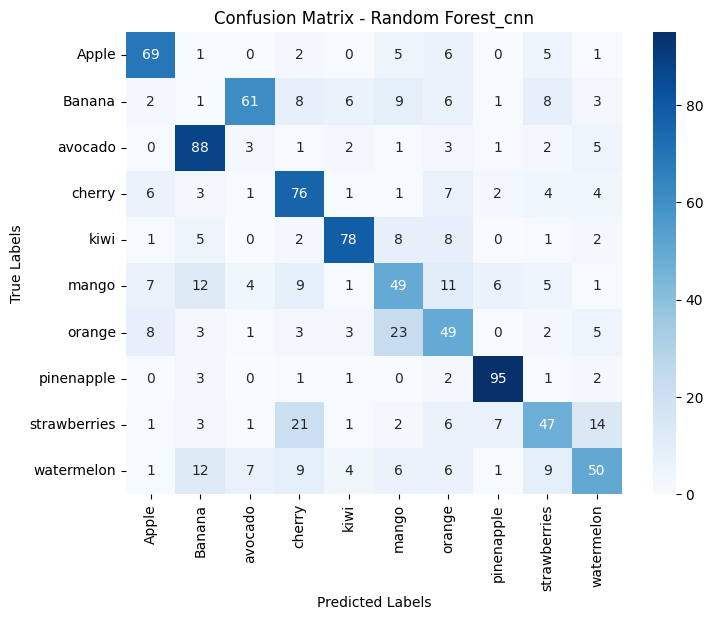

In [20]:
# Lưu kết quả đánh giá
results = [evaluate_model(model, X, y, name) for name, model, X, y in models]

In [21]:
# Chuyển thành DataFrame
df = pd.DataFrame(results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)"])
from IPython.display import display
display(df)

,Model,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
0,KNN,22.731707,23.795005,22.731707,20.210141
1,KNN_cnn,42.634146,46.747310,42.634146,42.904981
2,SVM,37.365854,37.162180,37.365854,36.401908
3,SVM_cnn,55.804878,57.797939,55.804878,56.342719
4,Random Forest,45.073171,43.207741,45.073171,43.470805
5,Random Forest_cnn,50.439024,50.325003,50.439024,50.149452


<ipython-input-22-f2f3ffcd3989>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")


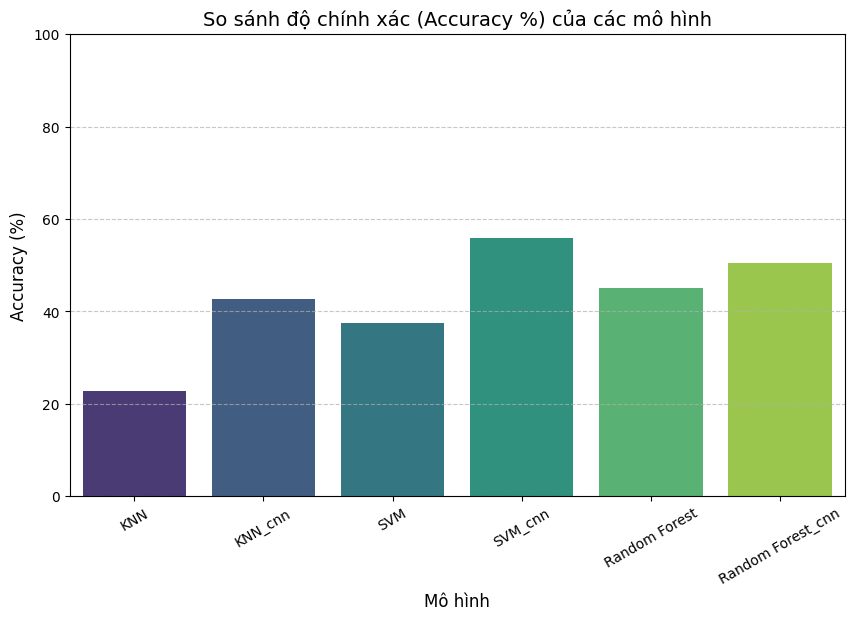

In [22]:
# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy (%)", data=df, palette="viridis")

# Thêm tiêu đề và nhãn
plt.title("So sánh độ chính xác (Accuracy %) của các mô hình", fontsize=14)
plt.xlabel("Mô hình", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(rotation=30)  # Xoay tên mô hình để dễ nhìn
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Hiển thị biểu đồ
plt.show()

<ipython-input-23-d011a54166de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score (%)", data=df, palette="viridis")


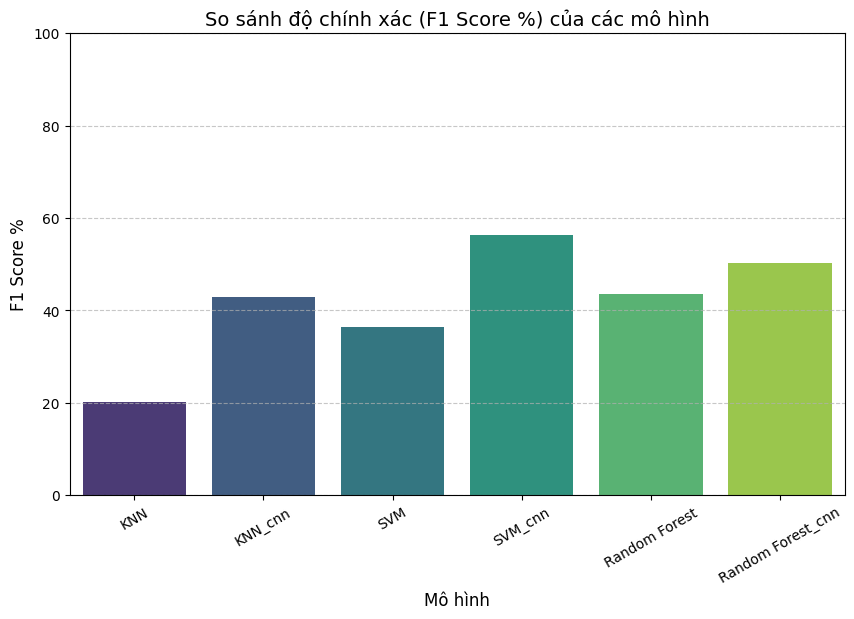

In [23]:
# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="F1 Score (%)", data=df, palette="viridis")

# Thêm tiêu đề và nhãn
plt.title("So sánh độ chính xác (F1 Score %) của các mô hình", fontsize=14)
plt.xlabel("Mô hình", fontsize=12)
plt.ylabel("F1 Score %", fontsize=12)
plt.xticks(rotation=30)  # Xoay tên mô hình để dễ nhìn
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Hiển thị biểu đồ
plt.show()